In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
import pandas as pd
from astropy.cosmology import Planck18

plt.rcParams.update({'font.size':20})

In [92]:
plot_dir = '/home/rwicker/plots'

In [93]:
simple_fit_coefs = []
complex_fit_coefs = []
double_complex_fit_coefs = []

simple_fit_errs = []
complex_fit_errs = []
double_complex_fit_errs = []

# Relaxed cluster CL0282 at z = 0.592

In [94]:
eff_leng_profiles = np.load(f'list_of_sph_leff_profiles_CL0282_snap107.npy')
eff_leng_errors = np.load(f'list_of_sph_leff_errors_CL0282_snap107.npy')
sph_radial_bins = np.load(f'list_of_sph_radial_bins_CL0282_snap107.npy')
print(eff_leng_errors.shape)
r500 = 1079.6435089526487
r200 = 1591.0
z = 0.592

colors = ['darkblue', 'darkgreen', 'crimson']
labels = [r'$3 \times R_{200}$', r'$4 \times R_{200}$', r'$7 \times R_{200}$']

(3, 151)


In [95]:
valid_radii = []
valid_profiles = []
valid_errors = []
for i, profile in enumerate(eff_leng_profiles):
    valid_radii.append(sph_radial_bins[i,(~np.isnan(profile))])
    valid_profiles.append(profile[(~np.isnan(profile))])
    valid_errors.append(eff_leng_errors[i,(~np.isnan(profile))])

### Limit the fit between the PSF of NIKA2 and $2R_{500}$

In [96]:
lower_limit = 12 * Planck18.kpc_proper_per_arcmin(z).value/60
upper_limit = r200 #r500

to_fit_radii = []
to_fit_profiles = []
to_fit_errors = []

for i, radius in enumerate(valid_radii):
    to_fit_radii.append(radius[(radius > lower_limit) & (radius < upper_limit)])
    to_fit_profiles.append(valid_profiles[i][(radius > lower_limit) & (radius < upper_limit)])
    to_fit_errors.append(valid_errors[i][(radius > lower_limit) & (radius < upper_limit)])

### Test a simple parametric model : $l_{eff} (R) = A_0 R_{500} \times \left (\frac{R}{R_{500}} \right)^{\alpha_0}$

In [97]:
def simple_test_profile(r, amplitude, alpha):
    return amplitude * r500 * (r/r500)**alpha 

In [98]:
simple_fitted_profile, simple_fitted_cov = curve_fit(simple_test_profile, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1])
simple_fitted_errors = np.sqrt(np.diag(simple_fitted_cov))

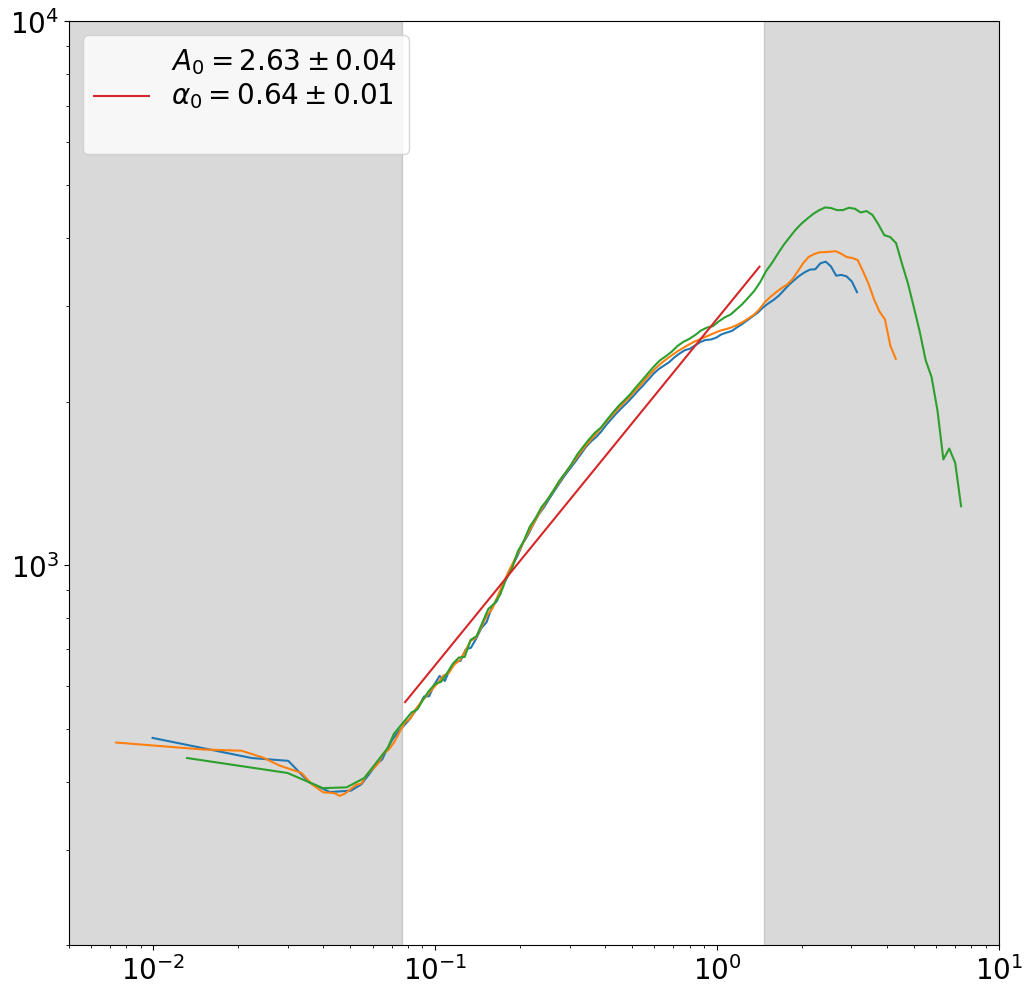

In [99]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles):
    ax.loglog(valid_radii[i]/r500, profile)
ax.loglog(to_fit_radii[1]/r500, simple_test_profile(to_fit_radii[1],*simple_fitted_profile), 
           label=f"$A_0 = {simple_fitted_profile[0]:.2f} \pm {simple_fitted_errors[0]:.2f}$"+"\n"+
           r"$\alpha_0$"+f"$= {simple_fitted_profile[1]:.2f} \pm {simple_fitted_errors[1]:.2f}$"+"\n")
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(2e2, 1e4)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/simple_fit_CL0282.png')

In [100]:
simple_fit_coefs.append(simple_fitted_profile)
simple_fit_errs.append(simple_fitted_errors)

### Test a more complex model, inspired from Vikhlinin & Kravtsov temperature models / highpass filters transfer function:
### $l_{eff} = A_0 R_{500} \frac{\left(B_0\frac{R}{R_{500}}\right)^{\alpha_0}}{\left(1 + \left(B_0\frac{R}{R_{500}}\right)^{\beta_0}\right)^{\gamma_0/\beta_0}} $

In [101]:
def complex_model(r, a0, b0, alpha, beta, gamma):
    return a0*r500*(b0*r/r500)**alpha/(1 + (b0*r/r500)**beta)**(gamma/beta)

In [102]:
complexified_fitted_profile, complexified_fitted_cov = curve_fit(complex_model, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1], maxfev=500000)
complexified_fitted_errors = np.sqrt(np.diag(complexified_fitted_cov))

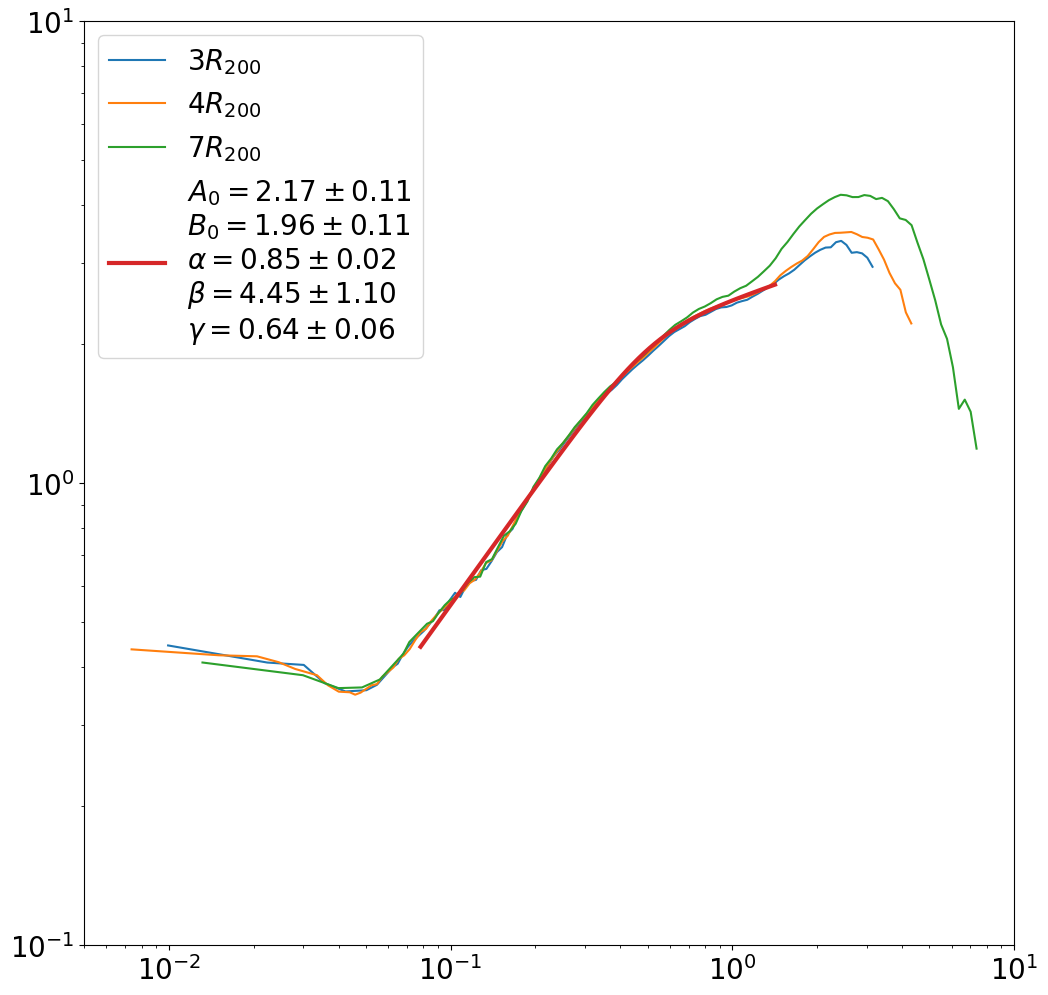

In [103]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles):
    int_length = ['3','4', '7'][i]
    ax.loglog(valid_radii[i]/r500, profile/r500, label = f'{int_length}'+'$R_{200}$')
ax.loglog(to_fit_radii[1]/r500, complex_model(to_fit_radii[1], *complexified_fitted_profile)/r500, 
           label=f"$A_0 = {complexified_fitted_profile[0]:.2f} \pm {complexified_fitted_errors[0]:.2f}$"+"\n"+
           f"$B_0 = {complexified_fitted_profile[1]:.2f}\pm {complexified_fitted_errors[1]:.2f}$"+"\n"+
           r"$\alpha$"+f"$ = {complexified_fitted_profile[2]:.2f}\pm {complexified_fitted_errors[2]:.2f}$"+"\n"+
           r"$\beta$"+f"$ = {complexified_fitted_profile[3]:.2f}\pm {complexified_fitted_errors[3]:.2f}$"+"\n"+
           r"$\gamma$"+f"$ = {complexified_fitted_profile[4]:.2f}\pm {complexified_fitted_errors[4]:.2f}$", lw=3)
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(0.1, 10)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/complex_fit_CL0282.png')

In [104]:
complex_fit_coefs.append(complexified_fitted_profile)
complex_fit_errs.append(complexified_fitted_errors)

### Try with doubling the model ?
### $l_{eff} = \left[ \left(A_0 R_{500} \frac{\left(B_0\frac{R}{R_{500}}\right)^{\alpha_0}}{\left(1 + C_0\frac{R}{R_{500}}\right)^{\beta_0}}\right)^2 + \left(A_1 R_{500} \frac{\left(B_1\frac{R}{R_{500}}\right)^{\alpha_1}}{\left(1 + C_1\frac{R}{R_{500}}\right)^{\beta_1}}\right)^2 \right]^{1/2}$

In [105]:
def double_complex_model(r, a0, b0, alpha0, beta0, gamma0, a1, b1, alpha1, beta1, gamma1):
    return np.sqrt((a0*r500*(b0*r/r500)**alpha0/(1 + (b0*r/r500)**beta0)**(gamma0/beta0))**2 + 
                   (a1*r500*(b1*r/r500)**alpha1/(1 + (b1*r/r500)**beta1)**(gamma1/beta1))**2)


In [106]:
doubly_complexified_fitted_profile, doubly_complexified_fitted_cov = curve_fit(double_complex_model, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1], maxfev=500000)
doubly_complexified_fitted_errors = np.sqrt(np.diag(doubly_complexified_fitted_cov))

/tmp/ipykernel_357894/2680818821.py:2: RuntimeWarning: overflow encountered in divide
  return np.sqrt((a0*r500*(b0*r/r500)**alpha0/(1 + (b0*r/r500)**beta0)**(gamma0/beta0))**2 +
/tmp/ipykernel_357894/2680818821.py:2: RuntimeWarning: overflow encountered in square
  return np.sqrt((a0*r500*(b0*r/r500)**alpha0/(1 + (b0*r/r500)**beta0)**(gamma0/beta0))**2 +


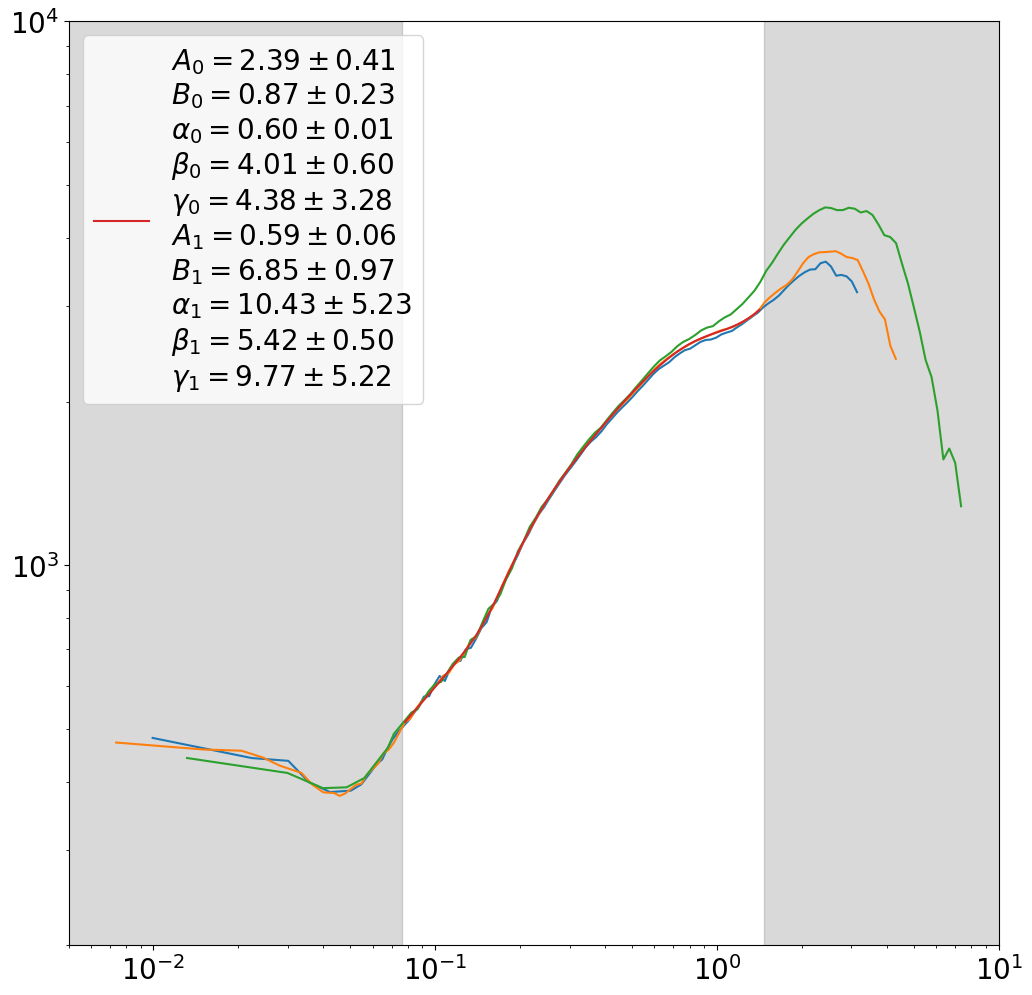

In [107]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles):
    ax.loglog(valid_radii[i]/r500, profile)
ax.loglog(to_fit_radii[1]/r500, double_complex_model(to_fit_radii[1], *doubly_complexified_fitted_profile), 
           label=f"$A_0 = {doubly_complexified_fitted_profile[0]:.2f} \pm {doubly_complexified_fitted_errors[0]:.2f}$"+"\n"+
           f"$B_0 = {doubly_complexified_fitted_profile[1]:.2f} \pm {doubly_complexified_fitted_errors[1]:.2f}$"+"\n"+
           r"$\alpha_0$"+f"$= {doubly_complexified_fitted_profile[2]:.2f} \pm {doubly_complexified_fitted_errors[2]:.2f}$"+"\n"+
           r"$\beta_0$"+f"$ = {doubly_complexified_fitted_profile[3]:.2f} \pm {doubly_complexified_fitted_errors[3]:.2f}$"+"\n"+
           r"$\gamma_0$"+f"$ = {doubly_complexified_fitted_profile[4]:.2f} \pm {doubly_complexified_fitted_errors[4]:.2f}$"+"\n"+
           f"$A_1 = {doubly_complexified_fitted_profile[5]:.2f} \pm {doubly_complexified_fitted_errors[5]:.2f}$"+"\n"+
           f"$B_1 = {doubly_complexified_fitted_profile[6]:.2f} \pm {doubly_complexified_fitted_errors[6]:.2f}$"+"\n"+
           r"$\alpha_1$"+f"$ = {doubly_complexified_fitted_profile[7]:.2f} \pm {doubly_complexified_fitted_errors[7]:.2f}$"+"\n"+
           r"$\beta_1$"+f"$ = {doubly_complexified_fitted_profile[8]:.2f} \pm {doubly_complexified_fitted_errors[8]:.2f}$"+"\n"+
           r"$\gamma_1$"+f"$ = {doubly_complexified_fitted_profile[9]:.2f} \pm {doubly_complexified_fitted_errors[9]:.2f}$")
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(2e2, 1e4)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/double_complex_fit_CL0282.png')

In [108]:
double_complex_fit_coefs.append(doubly_complexified_fitted_profile)
double_complex_fit_errs.append(doubly_complexified_fitted_errors)

### Derive 2D map from profile

In [109]:
npix = round(4*r200/10)

if npix%2 == 0.:
    npix += 1
print(npix, npix%2)

637 1


In [110]:
def centered_distance_grid(n):
    x,y = np.meshgrid(np.linspace(-2*r200, 2*r200, n), np.linspace(-2*r200, 2*r200, n))
    return np.sqrt(x**2 + y**2)

4500.027555471189
4500.027555471189


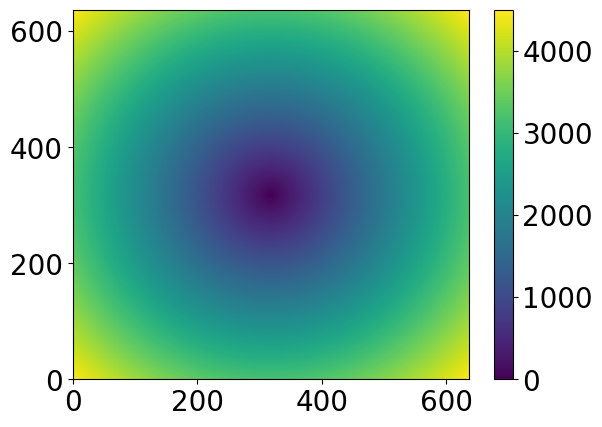

In [111]:
distance_map = plt.pcolormesh(centered_distance_grid(npix))
plt.colorbar(distance_map)
print(centered_distance_grid(npix).max())
print(2*np.sqrt(2)*r200)

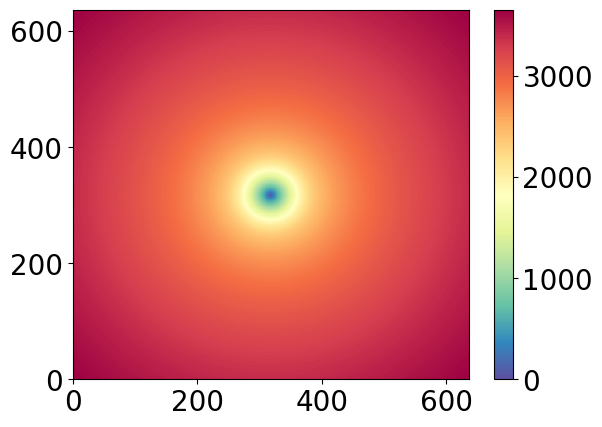

In [112]:
synthetic_leff = complex_model(centered_distance_grid(npix), *complexified_fitted_profile)
synthetic_leff_map = plt.pcolormesh(synthetic_leff, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

In [113]:
np.save(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/synthetic_leff_map_CL0282_snap107.npy', synthetic_leff)

# Disturbed cluster CL0009 at z = 0.7

In [114]:
eff_leng_profiles = np.load(f'list_of_sph_leff_profiles_CL0009_snap104.npy')
eff_leng_errors = np.load(f'list_of_sph_leff_errors_CL0009_snap104.npy')
sph_radial_bins = np.load(f'list_of_sph_radial_bins_CL0009_snap104.npy')
r500 = 1396.3348431655181
r200 = 2151.59
z = 0.7

colors = ['darkblue', 'darkgreen', 'crimson']
labels = [r'$3 \times R_{200}$', r'$4 \times R_{200}$', r'$7 \times R_{200}$']

In [115]:
valid_radii = []
valid_profiles = []
valid_errors = []
for i, profile in enumerate(eff_leng_profiles):
    valid_radii.append(sph_radial_bins[i,(~np.isnan(profile))])
    valid_profiles.append(profile[(~np.isnan(profile))])
    valid_errors.append(eff_leng_errors[i,(~np.isnan(profile))])

In [116]:
lower_limit = 12 * Planck18.kpc_proper_per_arcmin(z).value/60
upper_limit = r200 #r500

to_fit_radii = []
to_fit_profiles = []
to_fit_errors = []

for i, radius in enumerate(valid_radii):
    to_fit_radii.append(radius[(radius > lower_limit) & (radius < upper_limit)])
    to_fit_profiles.append(valid_profiles[i][(radius > lower_limit) & (radius < upper_limit)])
    to_fit_errors.append(valid_errors[i][(radius > lower_limit) & (radius < upper_limit)])

### Using the simple model

In [117]:
simple_fitted_profile, simple_fitted_cov = curve_fit(simple_test_profile, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1])
simple_fitted_errors = np.sqrt(np.diag(simple_fitted_cov))

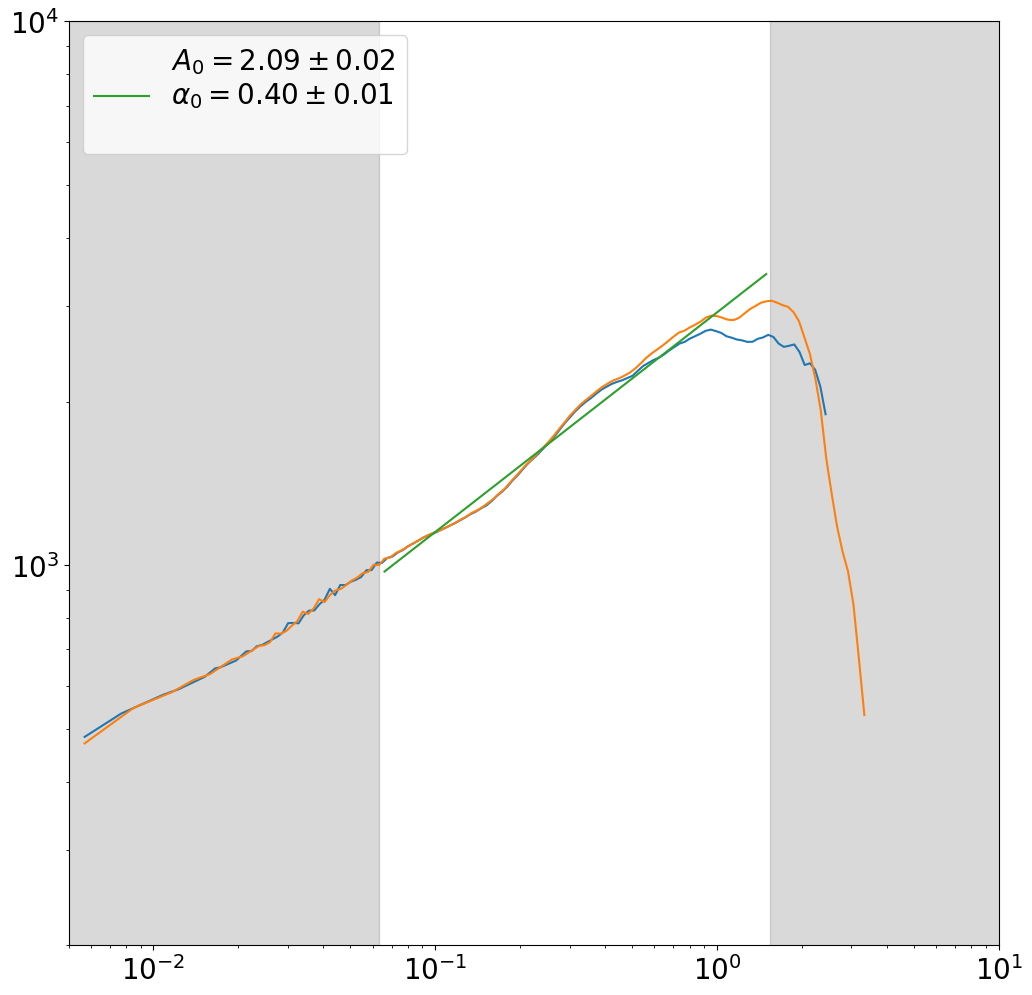

In [118]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles[:-1]):
    ax.loglog(valid_radii[i]/r500, profile)
ax.loglog(to_fit_radii[1]/r500, simple_test_profile(to_fit_radii[1],*simple_fitted_profile), 
           label=f"$A_0 = {simple_fitted_profile[0]:.2f} \pm {simple_fitted_errors[0]:.2f}$"+"\n"+
           r"$\alpha_0$"+f"$= {simple_fitted_profile[1]:.2f} \pm {simple_fitted_errors[1]:.2f}$"+"\n")
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(2e2, 1e4)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/simple_fit_CL0009.png')

In [119]:
simple_fit_coefs.append(simple_fitted_profile)
simple_fit_errs.append(simple_fitted_errors)

### Using the complexified model

In [120]:
complexified_fitted_profile, complexified_fitted_cov = curve_fit(complex_model, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1], maxfev=500000)
complexified_fitted_errors = np.sqrt(np.diag(complexified_fitted_cov))

/tmp/ipykernel_357894/1382498989.py:2: RuntimeWarning: invalid value encountered in power
  return a0*r500*(b0*r/r500)**alpha/(1 + (b0*r/r500)**beta)**(gamma/beta)


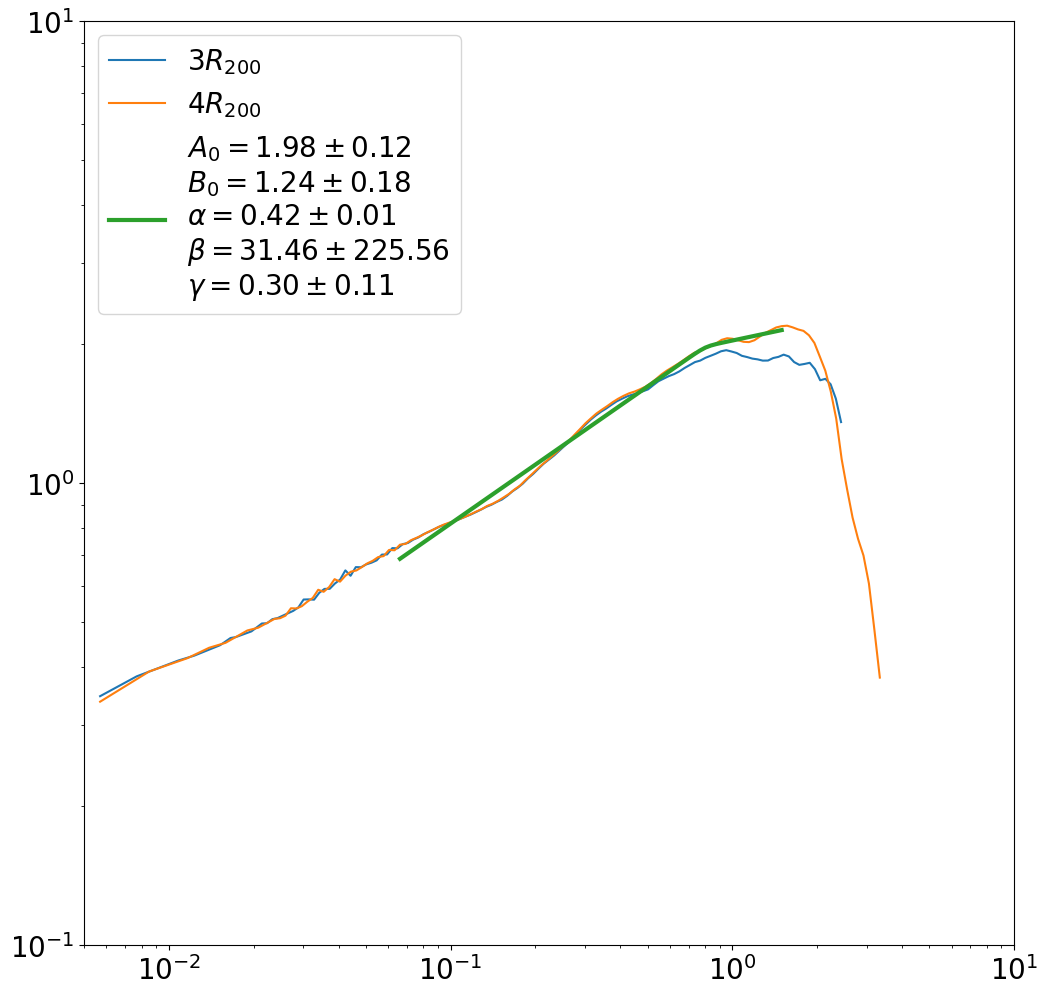

In [121]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles[:-1]):
    int_length = ['3','4', '7'][i]
    ax.loglog(valid_radii[i]/r500, profile/r500, label = f'{int_length}'+'$R_{200}$')
ax.loglog(to_fit_radii[1]/r500, complex_model(to_fit_radii[1], *complexified_fitted_profile)/r500, 
           label=f"$A_0 = {complexified_fitted_profile[0]:.2f} \pm {complexified_fitted_errors[0]:.2f}$"+"\n"+
           f"$B_0 = {complexified_fitted_profile[1]:.2f}\pm {complexified_fitted_errors[1]:.2f}$"+"\n"+
           r"$\alpha$"+f"$ = {complexified_fitted_profile[2]:.2f}\pm {complexified_fitted_errors[2]:.2f}$"+"\n"+
           r"$\beta$"+f"$ = {complexified_fitted_profile[3]:.2f}\pm {complexified_fitted_errors[3]:.2f}$"+"\n"+
           r"$\gamma$"+f"$ = {complexified_fitted_profile[4]:.2f}\pm {complexified_fitted_errors[4]:.2f}$", lw=3)
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(0.1, 10)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/complex_fit_CL0009.png')

In [122]:
complex_fit_coefs.append(complexified_fitted_profile)
complex_fit_errs.append(complexified_fitted_errors)

### Double complex model

In [123]:
doubly_complexified_fitted_profile, doubly_complexified_fitted_cov = curve_fit(double_complex_model, xdata=to_fit_radii[1], ydata=to_fit_profiles[1], sigma=to_fit_errors[1], maxfev=500000)
doubly_complexified_fitted_errors = np.sqrt(np.diag(doubly_complexified_fitted_cov))

/tmp/ipykernel_357894/2680818821.py:3: RuntimeWarning: overflow encountered in square
  (a1*r500*(b1*r/r500)**alpha1/(1 + (b1*r/r500)**beta1)**(gamma1/beta1))**2)
/tmp/ipykernel_357894/2680818821.py:2: RuntimeWarning: invalid value encountered in power
  return np.sqrt((a0*r500*(b0*r/r500)**alpha0/(1 + (b0*r/r500)**beta0)**(gamma0/beta0))**2 +
/tmp/ipykernel_357894/2680818821.py:3: RuntimeWarning: invalid value encountered in power
  (a1*r500*(b1*r/r500)**alpha1/(1 + (b1*r/r500)**beta1)**(gamma1/beta1))**2)


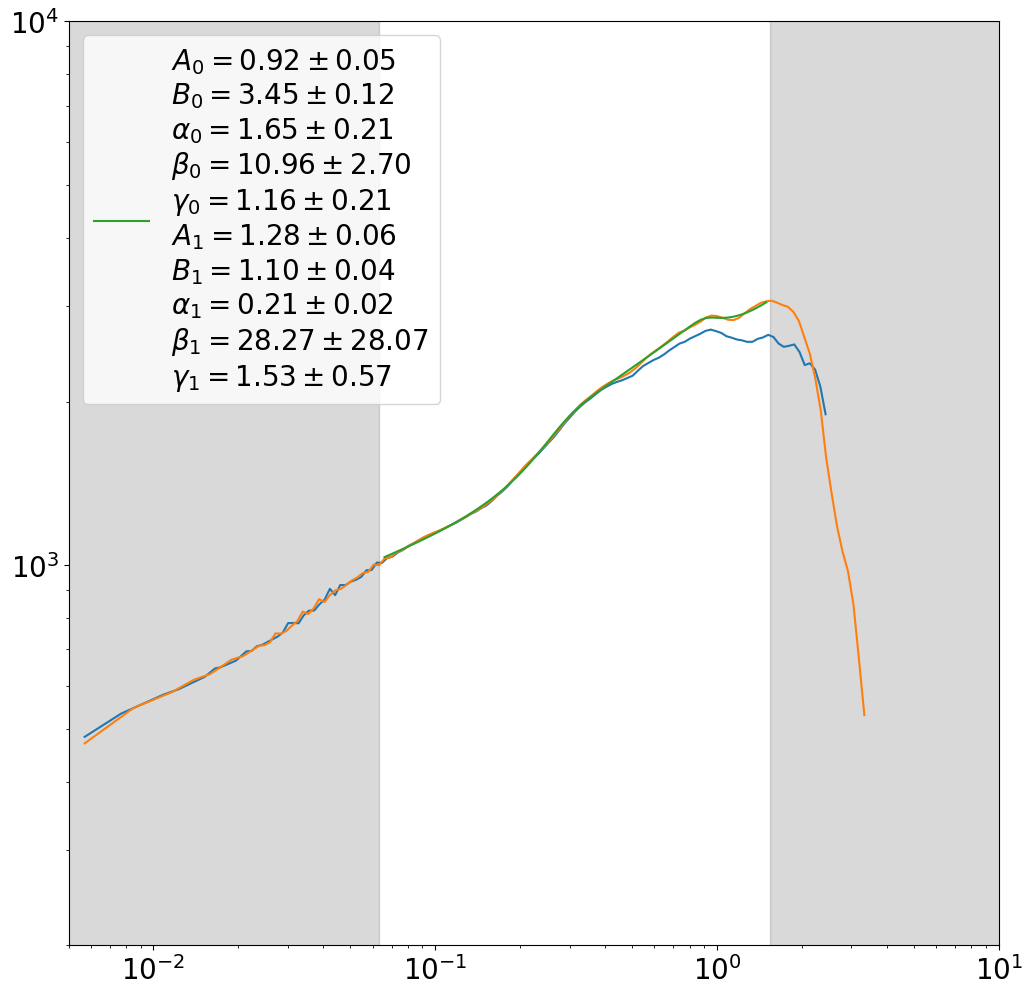

In [124]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
for i, profile in enumerate(valid_profiles[:-1]):
    ax.loglog(valid_radii[i]/r500, profile)
ax.loglog(to_fit_radii[1]/r500, double_complex_model(to_fit_radii[1], *doubly_complexified_fitted_profile), 
           label=f"$A_0 = {doubly_complexified_fitted_profile[0]:.2f} \pm {doubly_complexified_fitted_errors[0]:.2f}$"+"\n"+
           f"$B_0 = {doubly_complexified_fitted_profile[1]:.2f} \pm {doubly_complexified_fitted_errors[1]:.2f}$"+"\n"+
           r"$\alpha_0$"+f"$ = {doubly_complexified_fitted_profile[2]:.2f} \pm {doubly_complexified_fitted_errors[2]:.2f}$"+"\n"+
           r"$\beta_0$"+f"$ = {doubly_complexified_fitted_profile[3]:.2f} \pm {doubly_complexified_fitted_errors[3]:.2f}$"+"\n"+
           r"$\gamma_0$"+f"$ = {doubly_complexified_fitted_profile[4]:.2f} \pm {doubly_complexified_fitted_errors[4]:.2f}$"+"\n"+
           f"$A_1 = {doubly_complexified_fitted_profile[5]:.2f} \pm {doubly_complexified_fitted_errors[5]:.2f}$"+"\n"+
           f"$B_1 = {doubly_complexified_fitted_profile[6]:.2f} \pm {doubly_complexified_fitted_errors[6]:.2f}$"+"\n"+
           r"$\alpha_1$"+f"$  = {doubly_complexified_fitted_profile[7]:.2f} \pm {doubly_complexified_fitted_errors[7]:.2f}$"+"\n"+
           r"$\beta_1$"+f"$ = {doubly_complexified_fitted_profile[8]:.2f} \pm {doubly_complexified_fitted_errors[8]:.2f}$"+"\n"+
           r"$\gamma_1$"+f"$ = {doubly_complexified_fitted_profile[9]:.2f} \pm {doubly_complexified_fitted_errors[9]:.2f}$")
ax.fill_between([0., lower_limit/r500], 1e2, 1e4, color='k', alpha=0.15)
ax.fill_between([upper_limit/r500, 1e2], 1e2, 1e4, color='k', alpha=0.15)
ax.set_xlim(5e-3, 10)
ax.set_ylim(2e2, 1e4)
plt.legend(loc = 'upper left')

plt.savefig(f'{plot_dir}/double_complex_fit_CL0009.png')

In [125]:
double_complex_fit_coefs.append(doubly_complexified_fitted_profile)
double_complex_fit_errs.append(doubly_complexified_fitted_errors)

### 2D profile map

In [126]:
npix = round(4*r200/10)

if npix%2 == 0.:
    npix += 1
print(npix, npix%2)

861 1


In [127]:
def centered_distance_grid(n):
    x,y = np.meshgrid(np.linspace(-2*r200, 2*r200, n), np.linspace(-2*r200, 2*r200, n))
    return np.sqrt(x**2 + y**2)

6085.615517332656
6085.615517332656


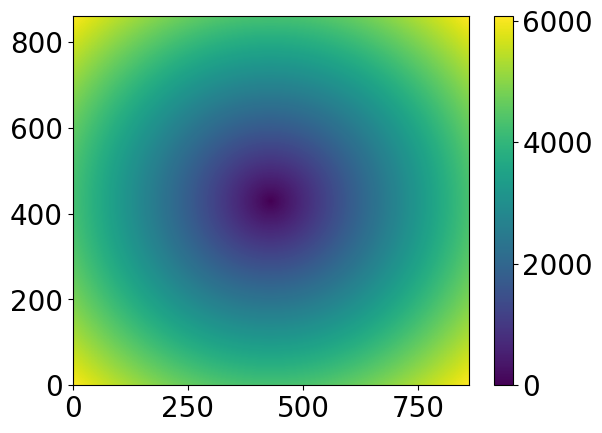

In [128]:
distance_map = plt.pcolormesh(centered_distance_grid(npix))
plt.colorbar(distance_map)
print(centered_distance_grid(npix).max())
print(2*np.sqrt(2)*r200)

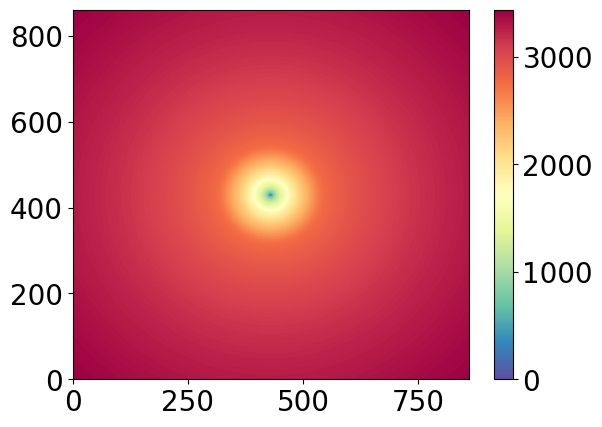

In [129]:
synthetic_leff = complex_model(centered_distance_grid(npix), *complexified_fitted_profile)
synthetic_leff_map = plt.pcolormesh(synthetic_leff, cmap='Spectral_r')
plt.colorbar(synthetic_leff_map)

In [130]:
np.save(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/synthetic_leff_map_CL0009_snap104.npy', synthetic_leff)

# Visualisation of the coefficients for the two clusters, in different models

In [131]:
print(simple_fit_coefs)
print(complex_fit_coefs)
print(double_complex_fit_coefs)

[array([2.62708242, 0.63650013]), array([2.08823965, 0.40371754])]
[array([2.17463924, 1.95603559, 0.84734793, 4.45376455, 0.63611815]), array([ 1.98115639,  1.24491148,  0.42420375, 31.4609227 ,  0.29507893])]
[array([ 2.39105454,  0.87306059,  0.60022575,  4.01405732,  4.38030149,
        0.58522248,  6.85134062, 10.43093951,  5.4242487 ,  9.76936494]), array([ 0.92474883,  3.45331297,  1.65293646, 10.96413244,  1.16054963,
        1.2771564 ,  1.09643725,  0.2095446 , 28.267941  ,  1.52518878])]


### Simple model

In [132]:
simple_profiles_df = pd.DataFrame(simple_fit_coefs, columns=['$A_0$', r'$\alpha_0$'], index=['CL0282', 'CL0009'])
complex_profiles_df = pd.DataFrame(complex_fit_coefs, columns=['$A_0$', '$B_0$', r'$\alpha_0$', r'$\beta_0$', r'$\gamma_0$'], index=['CL0282', 'CL0009'])
double_complex_profiles_df = pd.DataFrame(double_complex_fit_coefs, columns=['$A_0$', '$B_0$', r'$\alpha_0$', r'$\beta_0$', r'$\gamma_0$',
                                                                    '$A_1$', '$B_1$', r'$\alpha_1$', r'$\beta_1$', r'$\gamma_1$'],
                                                                    index=['CL0282', 'CL0009'])

simple_errors_df = pd.DataFrame(simple_fit_errs, columns=['$A_0$_e', r'$\alpha_0$_e'], index=['CL0282', 'CL0009'])
complex_errors_df = pd.DataFrame(complex_fit_errs, columns=['$A_0$_e', '$B_0$_e', r'$\alpha_0$_e', r'$\beta_0$_e', r'$\gamma_0$_e'], index=['CL0282', 'CL0009'])
double_complex_errors_df = pd.DataFrame(double_complex_fit_errs, columns=['$A_0$_e', '$B_0$_e', r'$\alpha_0$_e', r'$\beta_0$_e', r'$\gamma_0$_e',
                                                                    '$A_1$_e', '$B_1$_e', r'$\alpha_1$_e', r'$\beta_1$_e', r'$\gamma_1$_e'],
                                                                    index=['CL0282', 'CL0009'])

simple_df = pd.DataFrame()
complex_df = pd.DataFrame()
double_complex_df = pd.DataFrame()

for i in range(len(simple_profiles_df.columns)):
    simple_df = simple_df.append((simple_profiles_df.iloc[:, i]))
    simple_df = simple_df.append((simple_errors_df.iloc[:, i]))

simple_df = simple_df.T

for i in range(len(complex_profiles_df.columns)):
    complex_df = complex_df.append((complex_profiles_df.iloc[:, i]))
    complex_df = complex_df.append((complex_errors_df.iloc[:, i]))

complex_df = complex_df.T

for i in range(len(double_complex_profiles_df.columns)):
    double_complex_df = double_complex_df.append((double_complex_profiles_df.iloc[:, i]))
    double_complex_df = double_complex_df.append((double_complex_errors_df.iloc[:, i]))

double_complex_df = double_complex_df.T


/tmp/ipykernel_357894/1235890816.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_df = simple_df.append((simple_profiles_df.iloc[:, i]))
/tmp/ipykernel_357894/1235890816.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_df = simple_df.append((simple_errors_df.iloc[:, i]))
/tmp/ipykernel_357894/1235890816.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_df = simple_df.append((simple_profiles_df.iloc[:, i]))
/tmp/ipykernel_357894/1235890816.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simple_df = simple_df.append((simple_errors_df.iloc[:, i]))
/tmp/ipykernel_357894/1235890816.py:24: FutureWarning: T

In [133]:
simple_df

,$A_0$,$A_0$_e,$\alpha_0$,$\alpha_0$_e
CL0282,2.627082,0.042822,0.636500,0.013640
CL0009,2.088240,0.023594,0.403718,0.006233


In [134]:
complex_df

,$A_0$,$A_0$_e,$B_0$,$B_0$_e,$\alpha_0$,$\alpha_0$_e,$\beta_0$,$\beta_0$_e,$\gamma_0$,$\gamma_0$_e
CL0282,2.174639,0.113652,1.956036,0.105795,0.847348,0.016427,4.453765,1.098464,0.636118,0.059080
CL0009,1.981156,0.120319,1.244911,0.182278,0.424204,0.007040,31.460923,225.558167,0.295079,0.113559


In [135]:
double_complex_df

,$A_0$,$A_0$_e,$B_0$,$B_0$_e,$\alpha_0$,$\alpha_0$_e,$\beta_0$,$\beta_0$_e,$\gamma_0$,$\gamma_0$_e,$A_1$,$A_1$_e,$B_1$,$B_1$_e,$\alpha_1$,$\alpha_1$_e,$\beta_1$,$\beta_1$_e,$\gamma_1$,$\gamma_1$_e
CL0282,2.391055,0.414055,0.873061,0.231341,0.600226,0.012171,4.014057,0.600883,4.380301,3.278765,0.585222,0.061415,6.851341,0.967758,10.430940,5.231195,5.424249,0.496515,9.769365,5.224622
CL0009,0.924749,0.045617,3.453313,0.119056,1.652936,0.209544,10.964132,2.700781,1.160550,0.208838,1.277156,0.057163,1.096437,0.040680,0.209545,0.018004,28.267941,28.073099,1.525189,0.566521
